In [2]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path
path = Path.cwd().parents[0]
if str(path) not in sys.path:
    sys.path.append(str(path))

In [3]:
# Imports
trials = 50
n=100
noise = 0.5
kernel = "gaussian"

results_kl = torch.load(path / "causalklgp/ablation_causalklgp_ntrial={0}_n={1}_d=5_noise={2}_kernel={3}.pt".format(trials,n,noise, kernel),
                         weights_only = True)
results_bimp = torch.load(path / "bayesimp/ablation_bayesimp_ntrial={0}_n={1}_d=5_noise={2}_kernel={3}.pt".format(trials,n,noise, kernel),
                         weights_only = True)
results_bgp = torch.load(path / "baselinegp/ablation_baselinegp_ntrial={0}_n={1}_d=5_noise={2}_kernel={3}.pt".format(trials,n,noise, kernel),
                         weights_only = True)
results_rff = torch.load(path / "nystrom/ablation_nystrom_ntrial={0}_n=100_d=5_noise={2}_rff.pt".format(trials,n,noise, kernel),
                         weights_only = True)
results_ny = torch.load(path / "nystrom/ablation_nystrom_ntrial={0}_n=100_d=5_noise={2}_new.pt".format(trials,n,noise, kernel),
                         weights_only = True)
# Getting dimensions and names
levels = results_kl[0]['cal_levels']
n_level = len(levels)
n_result_kl = len(results_kl)
n_model_kl = int(n_result_kl/trials)
n_result_bimp = len(results_bimp)
n_model_bimp = int(n_result_bimp/trials)
n_result_bgp = len(results_bgp)
n_model_bgp = int(n_result_bgp/trials)
n_result_ny = len(results_ny)
n_model_ny = int(n_result_ny/trials)
n_result_rff = len(results_rff)
n_model_rff = int(n_result_rff/trials)
names = []

In [5]:
import numpy as np

# === RMSE Calculation ===

# Initialize RMSE tensors for each method
rmse_kl = torch.zeros(len(results_kl))
rmse_bimp = torch.zeros(len(results_bimp))
rmse_bgp = torch.zeros(len(results_bgp))
rmse_ny = torch.zeros(len(results_ny))
rmse_rff = torch.zeros(len(results_rff))

# Populate RMSE tensors with RMSE values from results
for i in range(len(results_kl)):
    rmse_kl[i] = results_kl[i]['rmse']

for i in range(len(results_bimp)):
    rmse_bimp[i] = results_bimp[i]['rmse']

for i in range(len(results_bgp)):
    rmse_bgp[i] = results_bgp[i]['rmse']
    
for i in range(len(results_ny)):
    rmse_ny[i] = results_ny[i]['rmse']

for i in range(len(results_rff)):
    rmse_rff[i] = results_rff[i]['rmse']

# Reshape RMSE tensors to [trials, n_models] and convert to NumPy arrays
rmse_kl = rmse_kl.reshape(n_model_kl, trials).T.numpy()
rmse_bimp = rmse_bimp.reshape(n_model_bimp, trials).T.numpy()
rmse_bgp = rmse_bgp.reshape(n_model_bgp, trials).T.numpy()
rmse_ny = rmse_ny.reshape(n_model_ny, trials).T.numpy()
rmse_rff = rmse_rff.reshape(n_model_rff, trials).T.numpy()

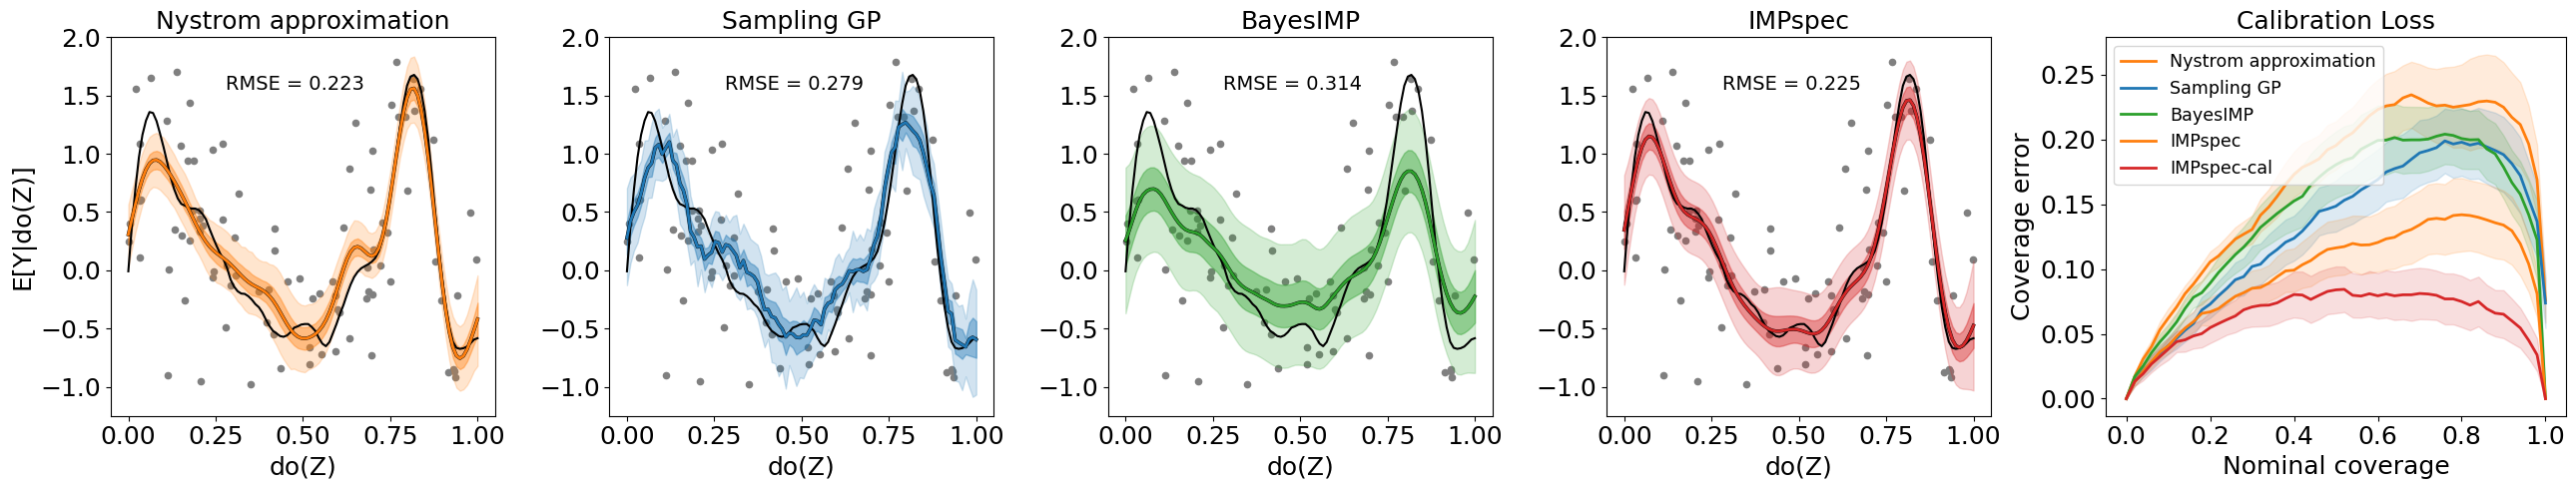

In [13]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

# === Options and Hyperparameters ===

# Plotting hyperparameters
z1 = 1.96   # Corresponds to approximately 95% credible interval
z2 = 0.674  # Corresponds to approximately 50% credible interval (IQR)
q1 = 0.975  # 95% credible interval (97.5th percentile)
q2 = 0.75   # 50% credible interval (75th percentile)

# Plot options
include_nystrom = True     # Set to True to include the Nystrom plot
grid_alpha = 0.0            # Adjust this value between 0 (transparent) and 1 (opaque)
show_legend = False         # Set to True to include legends in subplots
adjust_y_limits = True      # Set to True to adjust Y-axis limits, False to use default limits
y_limits = (-1.25, 2)       # Y-axis limits for the first three plots (if adjust_y_limits is True)

# Figure size options
plot_height = 5             # Height of all plots
plot_width = 5              # Width of individual plots (excluding the last plot)
last_plot_width = 6         # Width of the last plot

# Vertical separator options
include_separator = False          # Set to True to include the vertical separator
separator_position = None          # Float between 0 and 1 to adjust the separator position (None for default)
separator_thickness = 2            # Thickness of the separator line
separator_color = 'black'          # Color of the separator line

# Subplot spacing options
last_plot_spacing = None           # Relative width of the spacer column (e.g., 0.2 times the plot width)

# RMSE label options
base_fontsize = 12                     # Original font size
rmse_fontsize = int(base_fontsize * 1.2)  # Default size slightly larger than before
rmse_xpos_factor = 0.3                    # Default x-position factor, slightly closer to center
rmse_ypos_factor = 0.1                    # Default y-position factor (same height)

# RMSE data (Assumed to be provided)
# Each rmse_method is an array of shape [trials, n_models_method]
# Example: rmse = {'bgp': rmse_bgp, 'bimp': rmse_bimp, 'kl': rmse_kl}
rmse = {
    'bgp': rmse_bgp,   # Shape: [trials, n_model_bgp]
    'bimp': rmse_bimp, # Shape: [trials, n_model_bimp]
    'kl': rmse_kl      # Shape: [trials, n_model_kl]
}
if include_nystrom:
    rmse['ny'] = rmse_ny

# Reverse the order of methods and corresponding lists
methods = ['bgp', 'bimp', 'kl']
results = [results_bgp, results_bimp, results_kl]
post_types = ['samples', 'moments', 'moments']

# If include_nystrom is True, add the Nystrom method to the beginning of the lists
if include_nystrom:
    methods.insert(0, 'ny')      # Insert Nystrom at the beginning
    results.insert(0, results_ny)
    post_types.insert(0, 'samples')

# Mapping of methods to display names
method_names = {
    'kl': 'IMPspec',
    'ny': 'Nystrom approximation',
    'bimp': 'BayesIMP',
    'bgp': 'Sampling GP'
}

# Get default matplotlib colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map methods to default colors
method_colors = {
    'bgp': default_colors[0],   # default blue
    'bimp': default_colors[2],  # default green
    'kl': default_colors[3],    # default red
    'ny': default_colors[1]     # default orange (if included)
}

# For 'kl' calibration loss, assign specific colors to models
kl_model_colors = {
    0: default_colors[1],  # default orange (uncalibrated)
    2: default_colors[3],  # default red (calibrated)
}

# Font sizes
fontsize = int(base_fontsize * 1.5)    # Increase by 50%

# === End of Options and Hyperparameters ===

# Calculate total figure width based on individual plot widths
n_methods = len(methods)

if last_plot_spacing is not None:
    # Include the spacer column
    width_ratios = [1] * n_methods
    width_ratios.append(last_plot_spacing)
    width_ratios.append(last_plot_width / plot_width)
    ncols = n_methods + 2  # Number of columns including spacer and last plot
    wspace = 0             # No additional space between plots; spacer controls spacing
else:
    # No spacer column
    width_ratios = [1] * n_methods
    width_ratios.append(last_plot_width / plot_width)
    ncols = n_methods + 1  # Number of columns (no spacer)
    wspace = None          # Use default spacing between subplots

fig_width = sum(width_ratios) * plot_width
fig = plt.figure(figsize=(fig_width, plot_height))
gs = GridSpec(1, ncols, width_ratios=width_ratios, wspace=wspace)

axes = []
for idx in range(n_methods):
    ax = fig.add_subplot(gs[0, idx])
    axes.append(ax)

if last_plot_spacing is not None:
    # Skip the spacer column
    ax_calibration = fig.add_subplot(gs[0, n_methods + 1])
else:
    ax_calibration = fig.add_subplot(gs[0, n_methods])

axes.append(ax_calibration)

# Model indices used for RMSE (consistent with models plotted)
model_inds = {'bgp': [0], 'bimp': [1], 'kl': [2]}  # Adjust indices as needed
if include_nystrom:
    model_inds['ny'] = [0]

# Loop over each method to generate the individual plots
for idx, (ax, method, result_list, post_type) in enumerate(zip(axes[:-1], methods, results, post_types)):
    result = result_list[0]  # Assuming result_list is a list of results per method
    X, Y = result['obs_data']
    doX, EYdoX = result['int_data']

    color = method_colors[method]

    ax.scatter(X, Y, color="grey", s=20, label='Observations')
    ax.plot(doX, EYdoX, color="black", label='True Function')

    method_name = method_names[method]

    if post_type == 'moments':
        mu, var = result['post_moments']
        std = var.sqrt()
        ax.fill_between(
            doX.view(-1),
            (mu - z1 * std).view(-1),
            (mu + z1 * std).view(-1),
            alpha=0.2,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            (mu - z2 * std).view(-1),
            (mu + z2 * std).view(-1),
            alpha=0.4,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mu, color="black", lw=2.5)
        ax.plot(doX, mu, color=color, lw=2, label='Posterior mean')
    elif post_type == 'samples':
        EYdoX_s = result['post_samples'][0]
        # Handle transpose for specific methods if necessary
        if method == 'ny':
            EYdoX_s = EYdoX_s.T
        lower_q1 = EYdoX_s.quantile(1 - q1, dim=1)
        upper_q1 = EYdoX_s.quantile(q1, dim=1)
        lower_q2 = EYdoX_s.quantile(1 - q2, dim=1)
        upper_q2 = EYdoX_s.quantile(q2, dim=1)
        mean_prediction = EYdoX_s.mean(dim=1)

        ax.fill_between(
            doX.view(-1),
            lower_q1,
            upper_q1,
            alpha=0.2,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            lower_q2,
            upper_q2,
            alpha=0.4,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mean_prediction, color="black", lw=2.5)
        ax.plot(doX, mean_prediction, color=color, lw=2, label='Posterior mean')
    else:
        raise ValueError(f"Unknown post_type '{post_type}' for method '{method}'")

    # Update font sizes
    ax.set_title(f'{method_name}', fontsize=fontsize)
    ax.set_xlabel('do(Z)', fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('E[Y|do(Z)]', fontsize=fontsize)
    else:
        ax.set_ylabel('')

    # Set Y-axis limits if specified and adjust_y_limits is True
    if adjust_y_limits and y_limits is not None:
        ax.set_ylim(y_limits)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    if show_legend:
        ax.legend(fontsize=fontsize * 0.8)
    ax.grid(True, alpha=grid_alpha)

    # === Add RMSE Text ===
    rmse_method = rmse[method]  # Shape: [trials, n_models]
    model_idx = model_inds[method][0]  # Index of the model used in plotting
    mean_rmse = rmse_method[:, model_idx].mean()  # Average RMSE over trials for the selected model
    rmse_text = f'RMSE = {mean_rmse:.3f}'  # Format RMSE value with 3 decimal places

    # Determine position for the text
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_pos = xlim[0] + rmse_xpos_factor * (xlim[1] - xlim[0])  # Adjusted x-position
    y_pos = ylim[1] - rmse_ypos_factor * (ylim[1] - ylim[0])   # Same height as before

    # Add text to the plot
    ax.text(
        x_pos,
        y_pos,
        rmse_text,
        fontsize=rmse_fontsize,  # Use the new RMSE font size
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

# === Plotting the Calibration Loss ===

# Parameters and initializations
z = 1.96  # For 95% confidence interval
B = 100  # num bootstrap replications

n_models = {'bgp': n_model_bgp, 'bimp': n_model_bimp, 'kl': n_model_kl, 'ny': n_model_ny}
levels = levels.reshape(len(levels),)
n_level = len(levels)
# Initialize dictionaries to store results
levels_error = {}
import torch

# Initialize dictionaries to store the results
cal_loss = {}
cal_loss_B = {}
levels_error = {}

# Process results for calibration loss
for method, result_list in zip(methods, results):
    n_model = n_models[method]
    n_trials = trials

    # Initialize the calibration loss and bootstrap arrays
    levels_error[method] = torch.zeros((100, n_model, n_level, n_trials))
    cal_loss_B[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples
    
    # Calculate levels_error for each trial and model
    for m in range(n_model):
        for t in range(n_trials):
            index = n_trials * m + t
            levels_error[method][:, m, :, t] = result_list[index]['post_levels'] - levels.T[None]

    # Bootstrap procedure
    for b in range(B):
        # Subsample trials with replacement
        sampled_indices = torch.randint(0, n_trials, (n_trials,))

        # Compute bootstrap calibration loss for each model
        cal_loss_B[method][b] = levels_error[method][...,sampled_indices].mean(-1).abs().mean(0)

    # Compute the average calibration loss across all trials
    cal_loss[method] = levels_error[method].mean(-1).abs().mean(0)


# Now cal_loss contains the average calibration loss and cal_sd contains the standard error


# Plotting the calibration loss
ax_calibration = axes[-1]
ax_calibration.set_title('Calibration Loss', fontsize=fontsize)
ax_calibration.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration.set_ylabel('Coverage error', fontsize=fontsize)
ax_calibration.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration.grid(True, alpha=grid_alpha)

plot_inds = 2 * torch.arange(51)
model_inds_cal = {'bgp': [0], 'bimp': [1], 'kl': [0, 2], 'ny': [2]}  # Adjust indices as needed

# Loop over methods to plot calibration loss
for method in methods:
    cal_loss_mean = cal_loss[method]  # Mean over trials
    cal_loss_var = cal_loss_B[method].std(0)**2    # Variance over trials
    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            if method == 'kl':
                # Use specific colors for kl models
                model_color = kl_model_colors.get(i, default_colors[3])  # Default to red if not specified
                # Set specific labels for the 'kl' models
                if i == 0:
                    method_label = 'IMPspec'
                elif i == 2:
                    method_label = 'IMPspec-cal'
                else:
                    method_label = None  # No label for other models
            else:
                model_color = method_colors[method]
                method_label = method_names[method] if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            mean = cal_loss_mean.T[plot_inds, i]
            std_error = (cal_loss_var.T[plot_inds, i]**0.5)
            ax_calibration.plot(
                levels[plot_inds],
                mean,
                color=model_color,
                lw=2.0,
                label=method_label
            )
            ax_calibration.fill_between(
                levels[plot_inds],
                mean - z * std_error,
                mean + z * std_error,
                color=model_color,
                alpha=0.15
            )

# Include legend for the central estimates
ax_calibration.legend(fontsize=fontsize * 0.7, loc='upper left')  # Smaller font and moved to upper left

# === Add Vertical Separator ===

if include_separator:
    # Get the positions of the axes
    fig.canvas.draw()  # Draw the canvas to get updated positions
    axes_positions = [ax.get_position() for ax in axes]

    if last_plot_spacing is not None:
        # With spacer column
        if separator_position is not None:
            separator_x = separator_position
        else:
            # Default: position separator in the middle of the spacer column
            spacer_pos = gs[0, n_methods].get_position(fig)
            separator_x = (spacer_pos.x0 + spacer_pos.x1) / 2
    else:
        # No spacer column
        if separator_position is not None:
            separator_x = separator_position
        else:
            # Default: use default spacing between subplots
            pos_prev = axes_positions[n_methods - 1]
            pos_last = axes_positions[n_methods]
            separator_x = (pos_prev.x1 + pos_last.x0) / 2

    # Add vertical line
    line = Line2D(
        [separator_x, separator_x],  # x coordinates
        [0, 1],                      # y coordinates (from bottom to top)
        color=separator_color,
        linewidth=separator_thickness,
        transform=fig.transFigure,
        clip_on=False
    )
    fig.add_artist(line)

# Adjust layout
plt.tight_layout()
fig.savefig("Ablation_plots", bbox_inches="tight")
plt.show()


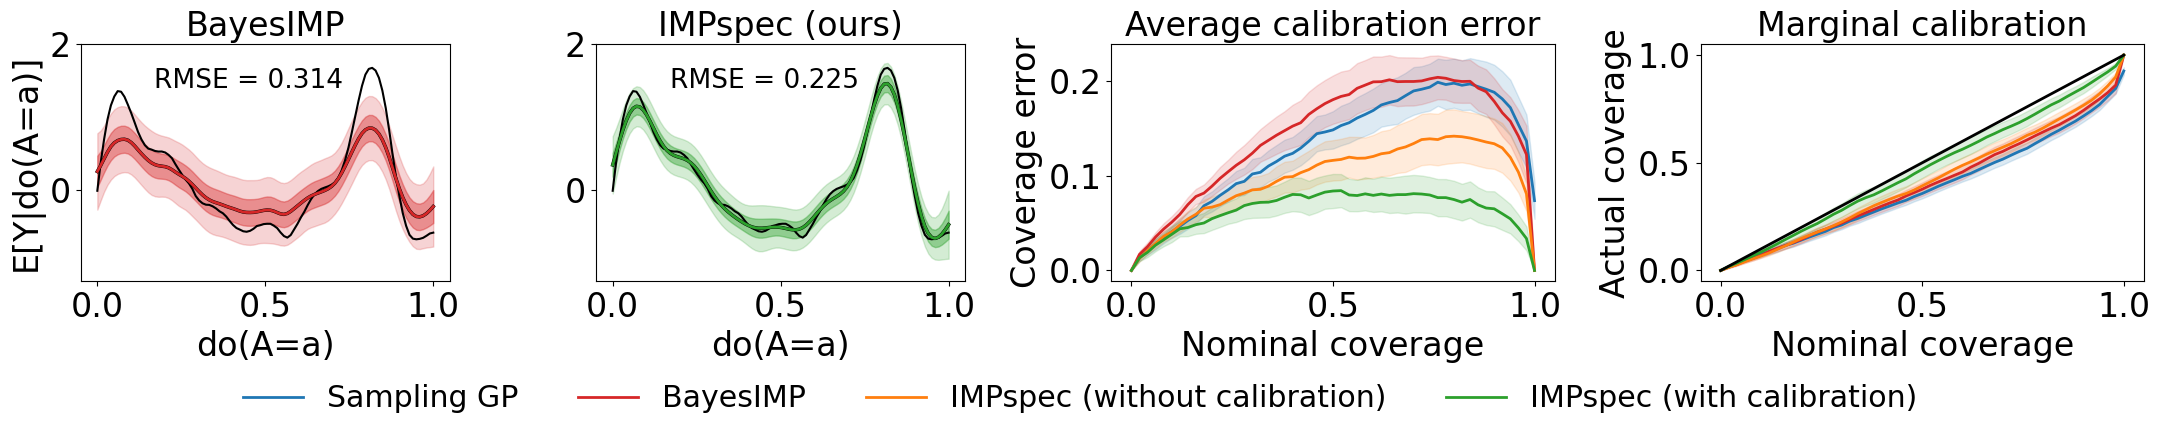

In [31]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

# === Options and Hyperparameters ===

# Plotting hyperparameters
z1 = 1.64   # Corresponds to approximately 90% credible interval
z2 = 0.674  # Corresponds to approximately 50% credible interval (IQR)
q1 = 0.95  # 95% credible interval (97.5th percentile)
q2 = 0.75   # 50% credible interval (75th percentile)

# Plot options
grid_alpha = 0.0            # Adjust this value between 0 (transparent) and 1 (opaque)
show_legend = False         # Set to True to include legends in subplots
adjust_y_limits = True      # Set to True to adjust Y-axis limits, False to use default limits
y_limits = (-1.25, 2)       # Y-axis limits for the first three plots (if adjust_y_limits is True)

# Figure size options
plot_height = 4.5             # Height of all plots
plot_width = 5              # Width of individual plots (excluding the last plot)
last_plot_width = 6         # Width of the last plot

# RMSE label options
base_fontsize = 16                     # Original font size
rmse_fontsize = int(base_fontsize * 1.2)  # Default size slightly larger than before
rmse_xpos_factor = 0.2                    # Default x-position factor, slightly closer to center
rmse_ypos_factor = 0.1                    # Default y-position factor (same height)

# RMSE data (Assumed to be provided)
# Each rmse_method is an array of shape [trials, n_models_method]
# Example: rmse = {'bimp': rmse_bimp, 'kl': rmse_kl}
rmse = {
    'bimp': rmse_bimp,  # Shape: [trials, n_model_bimp]
    'kl': rmse_kl       # Shape: [trials, n_model_kl]
}

# Reverse the order of methods and corresponding lists (Exclude Sampling GP plot)
methods = ['bimp', 'kl']
results = [results_bimp, results_kl]
post_types = ['moments', 'moments']

# Mapping of methods to display names
method_names = {
    'kl': 'IMPspec (ours)',
    'bimp': 'BayesIMP',
}

# Get default matplotlib colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map methods to default colors
method_colors = {
    'bimp': default_colors[3],  # default green
    'kl': default_colors[2],    # default red
}

# For 'kl' calibration loss, assign specific colors to models
kl_model_colors = {
    0: default_colors[1],  # default orange (uncalibrated)
    2: default_colors[2],  # default red (calibrated)
}

# Font sizes
fontsize = int(base_fontsize * 1.5)    # Increase by 50%

# === End of Options and Hyperparameters ===

# Calculate total figure width based on individual plot widths
n_methods = len(methods)

# Define grid spec (with two methods + calibration plot)
fig_width = (n_methods * plot_width) + 2 * last_plot_width  # Add space for two calibration plots
fig = plt.figure(figsize=(fig_width, plot_height))

# Adjust grid spec to handle two additional columns (for calibration and marginal calibration)
gs = GridSpec(1, n_methods + 2, width_ratios=[1] * n_methods + [last_plot_width / plot_width, last_plot_width / plot_width])

axes = []
for idx in range(n_methods):
    ax = fig.add_subplot(gs[0, idx])
    axes.append(ax)

# Calibration plot on the right-hand side
ax_calibration = fig.add_subplot(gs[0, n_methods])
axes.append(ax_calibration)

# Model indices used for RMSE (consistent with models plotted)
model_inds = {'bimp': [1], 'kl': [2]}  # Adjust indices as needed

# === Plot Individual Methods (BayesIMP and IMPspec) ===
# Loop over each method to generate the individual plots
for idx, (ax, method, result_list, post_type) in enumerate(zip(axes[:-1], methods, results, post_types)):
    result = result_list[0]  # Assuming result_list is a list of results per method
    X, Y = result['obs_data']
    doX, EYdoX = result['int_data']

    color = method_colors[method]

    #ax.scatter(X, Y, color="grey", s=20, label='Observations')
    ax.plot(doX, EYdoX, color="black", label='True Function')

    method_name = method_names[method]

    if post_type == 'moments':
        mu, var = result['post_moments']
        mu *= 1/trials
        var *= 1/trials
        for t in range(1,trials):
            mu += result_list[t]['post_moments'][0]/trials
            var += result_list[t]['post_moments'][1]/trials
        std = var.sqrt()
        ax.fill_between(
            doX.view(-1),
            (mu - z1 * std).view(-1),
            (mu + z1 * std).view(-1),
            alpha=0.2,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            (mu - z2 * std).view(-1),
            (mu + z2 * std).view(-1),
            alpha=0.4,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mu, color="black", lw=2.5)
        ax.plot(doX, mu, color=color, lw=2, label='Posterior mean')
    elif post_type == 'samples':
        EYdoX_s = result['post_samples'][0]
        # Handle transpose for specific methods if necessary
        if method == 'ny':
            EYdoX_s = EYdoX_s.T
        lower_q1 = EYdoX_s.quantile(1 - q1, dim=1)
        upper_q1 = EYdoX_s.quantile(q1, dim=1)
        lower_q2 = EYdoX_s.quantile(1 - q2, dim=1)
        upper_q2 = EYdoX_s.quantile(q2, dim=1)
        mean_prediction = EYdoX_s.mean(dim=1)

        ax.fill_between(
            doX.view(-1),
            lower_q1,
            upper_q1,
            alpha=0.2,
            color=color,
            label='95% credible interval'
        )
        ax.fill_between(
            doX.view(-1),
            lower_q2,
            upper_q2,
            alpha=0.4,
            color=color,
            label='Interquartile range'
        )
        ax.plot(doX, mean_prediction, color="black", lw=2.5)
        ax.plot(doX, mean_prediction, color=color, lw=2, label='Posterior mean')
    else:
        raise ValueError(f"Unknown post_type '{post_type}' for method '{method}'")

    # Update font sizes
    ax.set_title(f'{method_name}', fontsize=fontsize)
    ax.set_xlabel('do(A=a)', fontsize=fontsize)
    if idx == 0:
        ax.set_ylabel('E[Y|do(A=a)]', fontsize=fontsize)
    else:
        ax.set_ylabel('')

    # Set Y-axis limits if specified and adjust_y_limits is True
    if adjust_y_limits and y_limits is not None:
        ax.set_ylim(y_limits)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    if show_legend:
        ax.legend(fontsize=fontsize * 0.8)
    ax.grid(True, alpha=grid_alpha)

    # === Add RMSE Text ===
    rmse_method = rmse[method]  # Shape: [trials, n_models]
    model_idx = model_inds[method][0]  # Index of the model used in plotting
    mean_rmse = rmse_method[:, model_idx].mean()  # Average RMSE over trials for the selected model
    rmse_text = f'RMSE = {mean_rmse:.3f}'  # Format RMSE value with 3 decimal places

    # Determine position for the text
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_pos = xlim[0] + rmse_xpos_factor * (xlim[1] - xlim[0])  # Adjusted x-position
    y_pos = ylim[1] - rmse_ypos_factor * (ylim[1] - ylim[0])   # Same height as before

    # Add text to the plot
    ax.text(
        x_pos,
        y_pos,
        rmse_text,
        fontsize=rmse_fontsize,  # Use the new RMSE font size
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

# === Plotting the Calibration Loss (Calibration Plot) ===
# Loop over methods to plot calibration loss (Sampling GP is included in calibration)
methods = ['bgp', 'bimp', 'kl']
results = [results_bgp, results_bimp, results_kl]
post_types = ['samples', 'moments', 'moments']


# Mapping of methods to display names
method_names = {
    'kl': 'IMPspec',
    'bimp': 'BayesIMP',
    'bgp': 'Sampling GP'
}

# Get default matplotlib colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map methods to default colors
method_colors = {
    'bgp': default_colors[0],   # default blue
    'bimp': default_colors[3],  # default green
    'kl': default_colors[2],    # default red
}


ax_calibration.set_title('Average calibration error', fontsize=fontsize)
ax_calibration.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration.set_ylabel('Coverage error', fontsize=fontsize)
ax_calibration.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration.grid(True, alpha=grid_alpha)

plot_inds = 2 * torch.arange(51)
model_inds_cal = {'bgp': [0], 'bimp': [1], 'kl': [0, 2]}  # Sampling GP is included in calibration plot

for method in methods:
    cal_loss_mean = cal_loss[method]  # Mean over trials
    cal_loss_var = cal_loss_B[method].std(0)**2  # Variance over trials
    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            if method == 'kl':
                # Use specific colors for kl models
                model_color = kl_model_colors.get(i, default_colors[3])  # Default to red if not specified
                # Set specific labels for the 'kl' models
                if i == 0:
                    method_label = 'IMPspec-nocal'
                elif i == 2:
                    method_label = 'IMPspec'
                else:
                    method_label = None  # No label for other models
            else:
                model_color = method_colors[method]
                method_label = method_names[method] if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            mean = cal_loss_mean.T[plot_inds, i]
            std_error = (cal_loss_var.T[plot_inds, i]**0.5)
            ax_calibration.plot(
                levels[plot_inds],
                mean,
                color=model_color,
                lw=2.0,
                label=method_label
            )
            ax_calibration.fill_between(
                levels[plot_inds],
                mean - z * std_error,
                mean + z * std_error,
                color=model_color,
                alpha=0.15
            )

# Include legend for the calibration plot
#ax_calibration.legend(fontsize=fontsize * 0.7, loc='upper left')

# Compute cal_loss_marginal and cal_loss_B_marginal

cal_loss_marginal = {}
cal_loss_B_marginal = {}

for method, result_list in zip(methods, results):
    n_model = n_models[method]
    n_trials = trials

    # Initialize the calibration loss arrays
    levels_est = torch.zeros((100, n_model, n_level, n_trials))
    cal_loss_B_marginal[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples
    
    # Calculate levels_est for each trial and model (Replace the difference with direct estimates)
    for m in range(n_model):
        for t in range(n_trials):
            index = n_trials * m + t
            levels_est[:, m, :, t] = result_list[index]['post_levels']

    # Bootstrap procedure
    for b in range(B):
        # Subsample trials with replacement
        sampled_indices = torch.randint(0, n_trials, (n_trials,))

        # Compute bootstrap calibration loss for each model
        cal_loss_B_marginal[method][b] = levels_est[..., sampled_indices].mean(-1).mean(0)

    # Compute the average marginal calibration loss across all trials
    cal_loss_marginal[method] = levels_est.mean(-1).mean(0)


# Now cal_loss_marginal contains the average marginal calibration loss and cal_loss_B_marginal contains the standard error


# === Plotting the Marginal Calibration Loss (New Calibration Plot) ===
ax_calibration_marginal = fig.add_subplot(gs[0, n_methods + 1])
axes.append(ax_calibration_marginal)

ax_calibration_marginal.set_title('Marginal calibration', fontsize=fontsize)
ax_calibration_marginal.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration_marginal.set_ylabel('Actual coverage', fontsize=fontsize)
ax_calibration_marginal.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_marginal.grid(True, alpha=grid_alpha)

# Loop over methods to plot marginal calibration loss (Sampling GP is included)
for method in methods:
    cal_loss_marginal_mean = cal_loss_marginal[method]  # Mean over trials
    cal_loss_marginal_var = cal_loss_B_marginal[method].std(0)**2  # Variance over trials
    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            if method == 'kl':
                # Use specific colors for kl models
                model_color = kl_model_colors.get(i, default_colors[3])  # Default to red if not specified
                # Set specific labels for the 'kl' models
                if i == 0:
                    method_label = 'IMPspec (without calibration)'
                elif i == 2:
                    method_label = 'IMPspec (with calibration)'
                else:
                    method_label = None  # No label for other models
            else:
                model_color = method_colors[method]
                method_label = method_names[method] if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            mean = cal_loss_marginal_mean.T[plot_inds, i]
            std_error = (cal_loss_marginal_var.T[plot_inds, i]**0.5)
            ax_calibration_marginal.plot(
                levels[plot_inds],
                mean,
                color=model_color,
                lw=2.0,
                label=method_label
            )
            ax_calibration_marginal.fill_between(
                levels[plot_inds],
                mean - z * std_error,
                mean + z * std_error,
                color=model_color,
                alpha=0.15
            )
ax_calibration_marginal.plot(
    levels[plot_inds],
    levels[plot_inds],
    color="black",
    lw=2.0,
    label="_nolegend_"  # This ensures it won't show up in the legend
)
# Include legend for the marginal calibration plot
#ax_calibration_marginal.legend(fontsize=fontsize * 0.7, loc='upper left')

# Collect handles and labels from all axes
handles, labels = [], []
for ax in [axes[-1]]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while preserving order
by_label = dict(zip(labels, handles))

# Create a single legend at the bottom
fig.legend(
    by_label.values(),
    by_label.keys(),
    loc="lower center",
    ncol=len(by_label),          # spread horizontally
    fontsize=fontsize * 0.9,
    frameon=False
)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.15, 1, 1])
# alternatively:
# plt.subplots_adjust(bottom=0.15)

fig.savefig("Ablation_plots_with_Marginal_Calibration_new", bbox_inches="tight")
plt.show()

In [39]:
from tabulate import tabulate

# === LaTeX Table Generation ===

# Option to control standard error calculation
# Set to True to divide RMSE by sqrt(trials) and calibration scores by sqrt(trials)
# Set to False to divide RMSE by 1 and calibration scores by sqrt(n_levels)
use_sqrt_trials = False

# Create a dictionary to store RMSE arrays with updated method names
rmse = {
    'IMPspec': rmse_kl[:, 0],
    'BayesIMP-approx': rmse_bimp[:, 0],
    'BayesIMP': rmse_bimp[:, 1],
    'BayesIMP-opt': rmse_bimp[:, 2],
    'Sampling GP': rmse_bgp[:, 0]
}

# Add 'IMPspec-cal' for Model 1
rmse['IMPspec-cal'] = rmse_kl[:, 2] if rmse_kl.shape[1] > 1 else np.array([np.nan]*trials)
rmse['IMPspec-cal-nosplit'] = rmse_kl[:, 1] if rmse_kl.shape[1] > 1 else np.array([np.nan]*trials)

if include_nystrom:
    rmse['Nystrom approximation'] = rmse_ny[:, 0]

# Prepare table data
table = []
table_headers = ['Method', 'RMSE', 'Calibration Score']

# Define the mapping from display names to cal_loss keys and model indices
method_mapping = {
    'IMPspec': {'cal_loss_key': 'kl', 'model_idx': 0},          # Model 0
    'IMPspec-cal': {'cal_loss_key': 'kl', 'model_idx': 2},      # Model 1
    'IMPspec-cal-nosplit': {'cal_loss_key': 'kl', 'model_idx': 1},      # Model 1
    'BayesIMP-approx': {'cal_loss_key': 'bimp', 'model_idx': 0},
    'BayesIMP': {'cal_loss_key': 'bimp', 'model_idx': 1},
    'BayesIMP-opt': {'cal_loss_key': 'bimp', 'model_idx': 2},
    'Sampling GP': {'cal_loss_key': 'bgp', 'model_idx': 0},
    'Nystrom approximation': {'cal_loss_key': 'ny', 'model_idx': 0}
}

# Define the methods to include in the table with updated ordering
methods_for_table = ['Sampling GP', 'BayesIMP-approx', 'BayesIMP', 'BayesIMP-opt', 'IMPspec', 'IMPspec-cal','IMPspec-cal-nosplit']
if include_nystrom:
    methods_for_table.append('Nystrom approximation')

# Collect mean RMSE and Calibration Scores for identifying the best ones
rmse_means = {}
cal_means = {}

for method in methods_for_table:
    cal_loss_key = method_mapping[method]['cal_loss_key']
    model_idx = method_mapping[method]['model_idx']
    
    # Calculate mean and standard error for RMSE
    mean_rmse = rmse[method].mean()
    se_rmse = rmse[method].std(ddof=1) / np.sqrt(trials) if use_sqrt_trials else rmse[method].std(ddof=1)
    
    # Calculate mean and standard error for Calibration Score
    mean_cal = cal_loss[cal_loss_key][model_idx].mean() 
    se_cal = cal_loss_B[cal_loss_key].std(0)[model_idx].mean()
    
    # Store means for later comparison
    rmse_means[method] = mean_rmse
    cal_means[method] = mean_cal
    
    # Append to table with "mean ± se" formatting (temporary, will bold later)
    table.append([
        method, 
        f'{mean_rmse:.3f} ± {se_rmse:.3f}', 
        f'{mean_cal:.3f} ± {se_cal:.3f}'
    ])

# Identify the best (smallest) RMSE and Calibration Score
best_rmse_method = min(rmse_means, key=rmse_means.get)
best_cal_method = min(cal_means, key=cal_means.get)

# Bold the best RMSE and Calibration Score in the table
for i, row in enumerate(table):
    method = row[0]
    if method == best_rmse_method:
        # Bold the RMSE value
        mean_rmse, se_rmse = row[1].split(' ± ')
        table[i][1] = f'\\textbf{{{mean_rmse}}} ± {se_rmse}'
    if method == best_cal_method:
        # Bold the Calibration Score value
        mean_cal, se_cal = row[2].split(' ± ')
        table[i][2] = f'\\textbf{{{mean_cal}}} ± {se_cal}'

# Generate LaTeX table using tabulate and wrap it with \resizebox{\textwidth}{!}{...}
latex_table = "\\resizebox{\\textwidth}{!}{\n" + tabulate(
    table, 
    headers=table_headers, 
    tablefmt='latex_booktabs', 
    stralign='center', 
    floatfmt=".3f"
) + "\n}"

latex_table = latex_table.replace('\\textbackslash{}', '\\')
latex_table = latex_table.replace('\\textbf\\{', '\\textbf{')
latex_table = latex_table.replace('\\}', '}')

# Print the LaTeX table
print(latex_table)


\resizebox{\textwidth}{!}{
\begin{tabular}{ccc}
\toprule
        Method         &          RMSE          &   Calibration Score    \\
\midrule
      Sampling GP      &     0.279 ± 0.061      &     0.130 ± 0.009      \\
    BayesIMP-approx    &     0.366 ± 0.156      &     0.136 ± 0.015      \\
       BayesIMP        &     0.314 ± 0.082      &     0.143 ± 0.009      \\
     BayesIMP-opt      &     0.269 ± 0.086      &     0.094 ± 0.010      \\
        IMPspec        &     0.234 ± 0.080      &     0.104 ± 0.010      \\
      IMPspec-cal      &     0.225 ± 0.045      & \textbf{0.071} ± 0.007 \\
  IMPspec-cal-nosplit  &     0.225 ± 0.045      &     0.092 ± 0.009      \\
 Nystrom approximation & \textbf{0.223} ± 0.036 &     0.130 ± 0.009      \\
\bottomrule
\end{tabular}
}


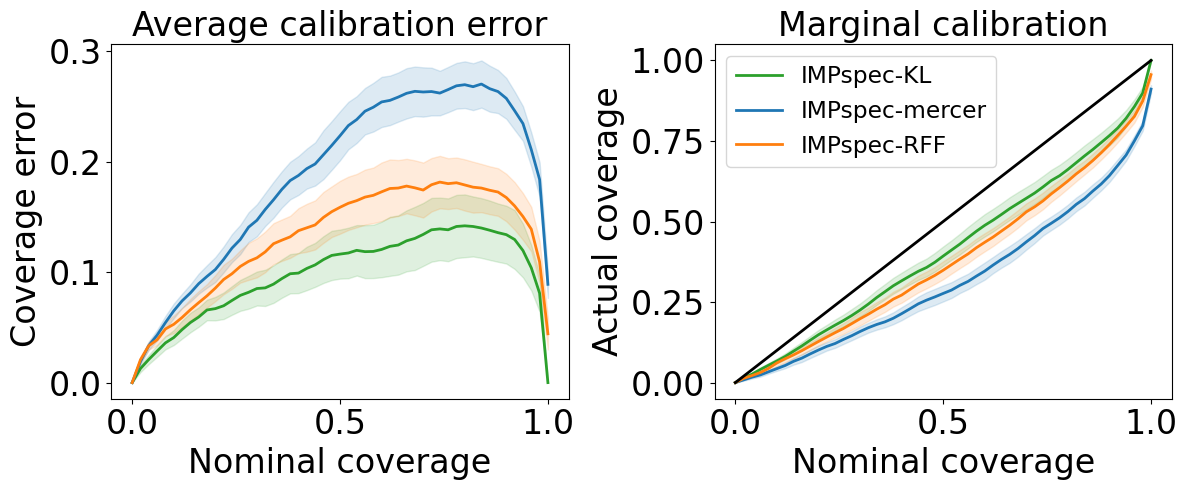

In [10]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

# === Options and Hyperparameters ===

# === Plotting the Calibration Loss (Calibration Plot) ===
# Loop over methods to plot calibration loss (Sampling GP is included in calibration)
methods = ['kl', 'ny', 'rff']
results = [results_kl,results_ny,results_rff]
post_types = ['moments', 'samples', 'samples']


# Mapping of methods to display names
method_names = {
    'kl': 'IMPspec-KL',
    'ny': 'IMPspec-mercer',
    'rff': 'IMPspec-RFF'
}

# Get default matplotlib colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map methods to default colors
method_colors = {
    'ny': default_colors[0],   # default blue
    'kl': default_colors[2],  # default green
    'rff': default_colors[1],    # default  orange
}

# Calibration plot on the right-hand side
# === Define Figure and GridSpec ===
fig = plt.figure(figsize=(12, 5))  # Adjust figure size accordingly
gs = GridSpec(1, 2, width_ratios=[1, 1])  # Define equal width for the two plots

# Define the two axes for the calibration plots
ax_calibration = fig.add_subplot(gs[0, 0])  # First plot
ax_calibration_marginal = fig.add_subplot(gs[0, 1])  # Second plot

# Adjust the spacing between the two plots
fig.subplots_adjust(wspace=0.3)  # Set the desired space between the plots (wspace)

n_models = {'kl': n_model_kl, 'ny': n_model_ny, 'rff': n_model_rff}
levels = levels.reshape(len(levels),)
n_level = len(levels)
# Initialize dictionaries to store results
levels_error = {}
import torch

# Initialize dictionaries to store the results
cal_loss = {}
cal_loss_B = {}
levels_error = {}

# Process results for calibration loss
for method, result_list in zip(methods, results):
    n_model = n_models[method]
    n_trials = trials

    # Initialize the calibration loss and bootstrap arrays
    levels_error[method] = torch.zeros((100, n_model, n_level, n_trials))
    cal_loss_B[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples
    
    # Calculate levels_error for each trial and model
    for m in range(n_model):
        for t in range(n_trials):
            index = n_trials * m + t
            levels_error[method][:, m, :, t] = result_list[index]['post_levels'] - levels.T[None]

    # Bootstrap procedure
    for b in range(B):
        # Subsample trials with replacement
        sampled_indices = torch.randint(0, n_trials, (n_trials,))

        # Compute bootstrap calibration loss for each model
        cal_loss_B[method][b] = levels_error[method][...,sampled_indices].mean(-1).abs().mean(0)

    # Compute the average calibration loss across all trials
    cal_loss[method] = levels_error[method].mean(-1).abs().mean(0)


ax_calibration.set_title('Average calibration error', fontsize=fontsize)
ax_calibration.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration.set_ylabel('Coverage error', fontsize=fontsize)
ax_calibration.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration.grid(True, alpha=grid_alpha)

plot_inds = 2 * torch.arange(51)
model_inds_cal = {'ny': [0], 'rff': [0], 'kl': [0]}  # Sampling GP is included in calibration plot

for method in methods:
    cal_loss_mean = cal_loss[method]  # Mean over trials
    cal_loss_var = cal_loss_B[method].std(0)**2  # Variance over trials
    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            model_color = method_colors[method]
            method_label = method_names[method] if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            mean = cal_loss_mean.T[plot_inds, i]
            std_error = (cal_loss_var.T[plot_inds, i]**0.5)
            ax_calibration.plot(
                levels.reshape(len(levels),)[plot_inds],
                mean,
                color=model_color,
                lw=2.0,
                label=method_label
            )
            ax_calibration.fill_between(
                levels.reshape(len(levels),)[plot_inds],
                mean - z * std_error,
                mean + z * std_error,
                color=model_color,
                alpha=0.15
            )

# Include legend for the calibration plot
#ax_calibration.legend(fontsize=fontsize * 0.7, loc='upper left')

# Compute cal_loss_marginal and cal_loss_B_marginal

cal_loss_marginal = {}
cal_loss_B_marginal = {}

for method, result_list in zip(methods, results):
    n_model = n_models[method]
    n_trials = trials

    # Initialize the calibration loss arrays
    levels_est = torch.zeros((100, n_model, n_level, n_trials))
    cal_loss_B_marginal[method] = torch.zeros((B, n_model, n_level))  # To store bootstrap samples
    
    # Calculate levels_est for each trial and model (Replace the difference with direct estimates)
    for m in range(n_model):
        for t in range(n_trials):
            index = n_trials * m + t
            levels_est[:, m, :, t] = result_list[index]['post_levels']

    # Bootstrap procedure
    for b in range(B):
        # Subsample trials with replacement
        sampled_indices = torch.randint(0, n_trials, (n_trials,))

        # Compute bootstrap calibration loss for each model
        cal_loss_B_marginal[method][b] = levels_est[..., sampled_indices].mean(-1).mean(0)

    # Compute the average marginal calibration loss across all trials
    cal_loss_marginal[method] = levels_est.mean(-1).mean(0)


# Now cal_loss_marginal contains the average marginal calibration loss and cal_loss_B_marginal contains the standard error


# === Plotting the Marginal Calibration Loss (New Calibration Plot) ===
ax_calibration_marginal.set_title('Marginal calibration', fontsize=fontsize)
ax_calibration_marginal.set_xlabel('Nominal coverage', fontsize=fontsize)
ax_calibration_marginal.set_ylabel('Actual coverage', fontsize=fontsize)
ax_calibration_marginal.tick_params(axis='both', which='major', labelsize=fontsize)
ax_calibration_marginal.grid(True, alpha=grid_alpha)

# Loop over methods to plot marginal calibration loss (Sampling GP is included)
for method in methods:
    cal_loss_marginal_mean = cal_loss_marginal[method]  # Mean over trials
    cal_loss_marginal_var = cal_loss_B_marginal[method].std(0)**2  # Variance over trials
    n_model = n_models[method]

    for i in range(n_model):
        if i in model_inds_cal[method]:
            model_color = method_colors[method]
            method_label = method_names[method] if i == model_inds_cal[method][0] else None  # Avoid duplicate labels

            mean = cal_loss_marginal_mean.T[plot_inds, i]
            std_error = (cal_loss_marginal_var.T[plot_inds, i]**0.5)
            ax_calibration_marginal.plot(
                levels.reshape(len(levels),)[plot_inds],
                mean,
                color=model_color,
                lw=2.0,
                label=method_label
            )
            ax_calibration_marginal.fill_between(
                levels.reshape(len(levels),)[plot_inds],
                mean - z * std_error,
                mean + z * std_error,
                color=model_color,
                alpha=0.15
            )
ax_calibration_marginal.plot(
    levels[plot_inds],
    levels[plot_inds],
    color="black",
    lw=2.0,
    label="_nolegend_"  # This ensures it won't show up in the legend
)
# Include legend for the marginal calibration plot
ax_calibration_marginal.legend(fontsize=fontsize * 0.7, loc='upper left')

plt.tight_layout()
fig.savefig("Ablation_plots_with_Marginal_Calibration_truncation", bbox_inches="tight")
plt.show()